In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import gaussian_kde, ttest_ind, pearsonr

import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS, OLS
from statsmodels.formula.api import wls

import warnings
warnings.filterwarnings('ignore')

def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w)) 

# Figure 1A

In [2]:
draw_df = pd.read_csv('data/city_vechile_transit.csv')

In [3]:
# Calculate the average car ownership and transit usage in each population bin
centers = []
transits = []
cars = []
y1s = []
y2s = []
y1s_car = []
y2s_car = []
csize = []
step = -0.2
wind = 0.6
for i in np.arange(7.2, 5.1, step): 
    temp = draw_df[(draw_df.log_pop > i-wind) & (draw_df.log_pop <= i)]
    if temp.shape[0] == 0:
        continue
    csize.append(temp.shape[0])
    centers.append(i - wind/2)
    transits.append(np.mean(temp['Transit']))
    cars.append(np.mean(temp['Car']))
    
    bstrap_result = []
    for k in range(1000):
        bstrap_result.append(temp['Transit'].sample(n = temp.shape[0], replace = True).mean())
    low, high = np.percentile(bstrap_result, [2.5, 97.5])
    low, high = np.percentile(bstrap_result, [0.5, 99.5])
    y1s.append(low)
    y2s.append(high)
    
    bstrap_result = []
    for k in range(1000):
        bstrap_result.append(temp['Car'].sample(n = temp.shape[0], replace = True).mean())
    low, high = np.percentile(bstrap_result, [2.5, 97.5])
    low, high = np.percentile(bstrap_result, [0.5, 99.5])
    y1s_car.append(low)
    y2s_car.append(high)

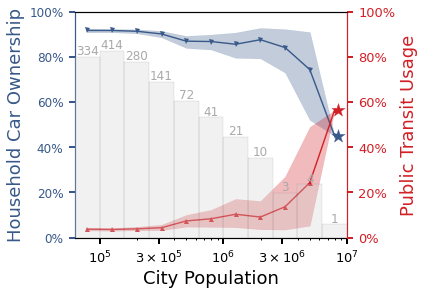

In [4]:
fig = plt.figure(figsize = (6, 4.2))
plt.style.use('seaborn-paper')
color1 = "#385989"
color2 = "#D22027"
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.bar(centers, height = np.log10(csize)+0.2, width = 0.2, edgecolor = 'black', color = 'lightgray', alpha = 0.3, zorder = 1.1)
for i,j in zip(centers, csize):
    ax3.text(i, np.log10(j)+0.23, str(j), ha = 'center', color = 'darkgray', size = 12)
ax3.set_ylim(0, 3.4)
ax1.plot(centers, cars, marker = 'v', color = color1, markersize = 5)
ax1.fill_between(centers, y1s_car, y2s_car, color = color1, alpha = 0.3)
ax2.plot(centers, transits, marker = '^', color = color2, markersize = 5)
ax2.fill_between(centers, y1s, y2s, color = color2, alpha = 0.3)
scatters = draw_df.iloc[[0]]
ax1.scatter(scatters['log_pop'], scatters['Car'], color = color1, s = 200, marker = '*')
ax2.scatter(scatters['log_pop'], scatters['Transit'], color = color2, s = 200, marker = '*')
ax1.set_ylabel('Household Car Ownership', fontsize = 18, color = color1)
ax1.tick_params(axis = 'y', length = 6, width = 2, color = color1, labelcolor = color1, labelsize = 12)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set(color = color1, linewidth = 1.2)
ax1.spines['bottom'].set(linewidth = 1.2)
ax1.spines['top'].set(linewidth = 1.2)
ax1.set_ylim(0, 1)
ax1.set_xticks([5, np.log10(3e5), 6, np.log10(3e6), 7])
ax1.set_xticklabels([r'$10^5$', r'$3\times10^5$', r'$10^6$', r'$3\times10^6$', r'$10^7$'])
ax1.set_xticks([np.log10(2e5), np.log10(5e5), np.log10(4e5), np.log10(6e5), np.log10(7e5), np.log10(8e5), np.log10(9e5), np.log10(2e6), np.log10(5e6), np.log10(4e6), np.log10(6e6), np.log10(7e6), np.log10(8e6), np.log10(9e6)], minor = True)
ax2.set_ylabel('Public Transit Usage', fontsize = 18, color = color2)
ax2.tick_params(axis = 'y', which='major', length = 6, width = 2, color = color2, labelcolor = color2, labelsize = 13)
ax2.tick_params(axis = 'y', which='minor', color = color2)
ax1.tick_params(axis = 'x', which='major', length = 6, width = 2, color = 'black', labelcolor = 'black', labelsize = 13)
ax1.tick_params(axis = 'x', which='minor', length = 2, width = 1, color = 'black')
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set(color = color2, linewidth = 1.2)
ax1.set_xlabel('City Population', fontsize = 18, color = 'black')
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax2.set_ylim(0, 1)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_yticks([])
plt.xlim(4.8, 7.0)
plt.tight_layout()
plt.show()

# Figure 1B

In [5]:
city_feats = pd.read_csv('data/nyc_features.csv')

In [6]:
# Correlation analysis & regression coefficients
temp = city_feats.dropna(subset = ['vehicle_rate' ,'public_transit_ratio'])
# temp = temp[city_feats['Total population'] > 100]
x = np.array(temp.vehicle_rate * 100)
y = np.array(temp.public_transit_ratio * 100)
w = temp['Total population']
print(pearsonr(x, y), corr(x, y, w = np.ones(x.shape)), corr(x, y, w))
X = sm.add_constant(x)
wls_model = sm.WLS(y,X, weights=w)
wls_model = sm.WLS(y,X)
r = wls_model.fit()
print(r.params)
x1 = [-1, 101]
y1 = [r.params[0]-r.params[1], r.params[0] + 101*r.params[1]]

PearsonRResult(statistic=-0.5945482488180345, pvalue=0.0) -0.5945482488180347 -0.6106966755809293
[77.16228316 -0.44041055]


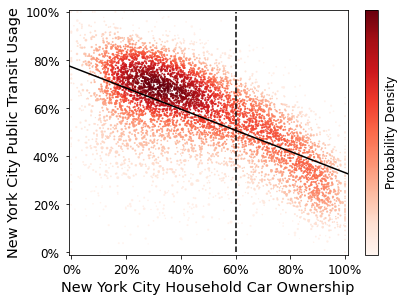

In [7]:
# Draw the lianhe probability distribution of car ownership and transit usage
temp = city_feats.dropna(subset = ['vehicle_rate' ,'public_transit_ratio'])
# temp = temp[city_feats['Total population'] > 100]
x = np.array(temp.vehicle_rate * 100).reshape(-1, 1)
y = np.array(temp.public_transit_ratio * 100).reshape(-1, 1)
xystack = np.vstack([temp.vehicle_rate * 100, temp.public_transit_ratio * 100])
w = temp['Total population']
z = gaussian_kde(xystack, weights = w)(xystack)
idx = z.argsort()
x, y, z, w = temp.vehicle_rate.iloc[idx]*100, temp.public_transit_ratio.iloc[idx]*100, z[idx], temp['Total population'].iloc[idx]

mycmap = mpl.colors.LinearSegmentedColormap.from_list('lwide', [(0, '#FFFFFF'), (1, '#9B112F')], N=512)
plt.figure(figsize = (6, 4.3))
plt.style.use('seaborn-paper')
plt.scatter(x, y, s = w / 500, c = z, cmap = 'Reds')
plt.plot(x1, y1, color = 'black', lw = 1.5)
cbar = plt.colorbar(ticks = [])
cbar.set_label(label = r'Probability Density', fontdict = {'size': 12})
plt.vlines(60, 0, 100, lw = 1.5, ls = '--', color = 'black')
plt.xlabel('New York City Household Car Ownership', size = 14.5)
plt.ylabel('New York City Public Transit Usage', size = 14.5)
plt.xticks([0, 20, 40, 60, 80, 100], ['0%', '20%', '40%', '60%', '80%', '100%'], size = 12)
plt.yticks([0, 20, 40, 60, 80, 100], ['0%', '20%', '40%', '60%', '80%', '100%'], size = 12)
plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.tight_layout()
plt.show()

# Figure 2A~F

In [8]:
feat_dict = {'reach': 'Accessible Radius (km)', 'job': 'Accessible Job Opportunities', 'poi': 'Accessible POIs', 'park': 'Accessible Parks', 'health1': 'Accessible Medical Institutions',
       'bank': 'Accessible Banks', 'education': 'Accessible Education Services', 'grocery': 'Accessible Grocery Stores', 'health': 'Accessible Healthcare Facilities', 'school': 'Accessible Schools'}

def draw_fig2_1(draw_feat = 'reach', thres = 0.6, sigs = [1,1,1]):
    pls = []
    y1s = []
    y2s = []
    colors = ['#D12920', '#2E59A7', '#32788A']
    title = feat_dict.get(draw_feat, None)
    for feat in ['non_Hispanic_white_ratio', 'Hispanic_ratio', 'non_Hispanic_black_ratio']:
        temp = city_feats[city_feats[feat] >= 0.5]
        temp = temp[temp['vehicle_rate'] <= thres]
        temp = temp.dropna(subset = [draw_feat])
        
        pls.append(np.average(temp[draw_feat], weights = temp['Total population']))
        bstrap_result = []
        for k in range(200):
            bstrap_result.append(temp[draw_feat].sample(n = temp.shape[0], replace = True, weights =  temp['Total population']).mean())
        low, high = np.percentile(bstrap_result, [2.5, 97.5])
        y1s.append(low)
        y2s.append(high)
    print(pls)
    plt.figure(figsize = (6, 4.5))
    plt.style.use('seaborn-paper')
    er = np.abs(np.array([y1s, y2s]) - np.array(pls))
    plt.bar([1,2,3], height = pls, width = 0.75, color = colors, edgecolor = colors,
            linewidth = 1, alpha = 0.6)
    for i in range(3):
        plt.errorbar([i+1], y = [pls[i]], yerr = er[:, i:i+1], fmt = 'o', markersize = 0, ecolor = colors[i],
                capsize = 20, elinewidth = 2, capthick = 1, alpha = 0.8)
    plt.xticks([1,2,3], ['White\nMajority', 'Hispanic\nMajority', 'Black\nMajority'], size = 16)
    plt.yticks(size = 13)
    plt.ylabel(title, size = 16)
    highest = np.max(y2s)
    lowest = 0
    ylim_low = 0
    plt.ylim(ylim_low, highest+(highest-lowest)/3)
    
    y0 = ylim_low
    y1 = highest+(highest-lowest)/3 - y0
    # 1vs2
    if sigs[0]:
        plt.vlines(1.05, ymin = y0 + 0.78*y1, ymax = y0+0.83*y1, lw = 0.75, color = 'black')
        plt.vlines(1.95, ymin = y0 + 0.78*y1, ymax = y0+0.83*y1, lw = 0.75, color = 'black')
        plt.hlines(y0+0.83*y1, 1.05, 1.95, lw = 0.75, color = 'black')
        plt.text(s = '***', x = 1.5, y = y0+0.84*y1, va = 'center', ha = 'center', size = 15)
    # 2vs3
    if sigs[1]:
        plt.vlines(2.05, ymin = y0 + 0.78*y1, ymax = y0+0.83*y1, lw = 0.75, color = 'black')
        plt.vlines(2.95, ymin = y0 + 0.78*y1, ymax = y0+0.83*y1, lw = 0.75, color = 'black')
        plt.hlines(y0+0.83*y1, 2.05, 2.95, lw = 0.75, color = 'black')
        plt.text(s = '***', x = 2.5, y = y0+0.84*y1, va = 'center', ha = 'center', size = 15)
    # 1vs3
    if sigs[2]:
        plt.vlines(1.05, ymin = y0 + 0.88*y1, ymax = y0+0.93*y1, lw = 0.75, color = 'black')
        plt.vlines(2.95, ymin = y0 + 0.88*y1, ymax = y0+0.93*y1, lw = 0.75, color = 'black')
        plt.hlines(y0+0.93*y1, 1.05, 2.95, lw = 0.75, color = 'black')
        plt.text(s = '***', x = 2, y = y0+0.94*y1, va = 'center', ha = 'center', size = 15)
    plt.tight_layout()
    plt.show()

[12.51320122664441, 11.160996436222199, 10.617252226578113]


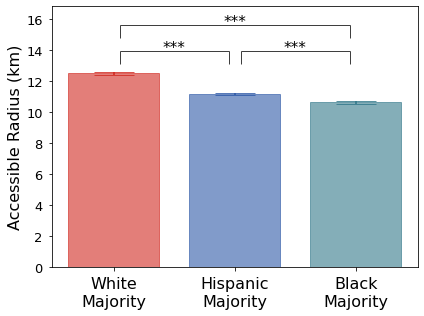

[3237131.8551817336, 2651021.7817578586, 2357207.328264676]


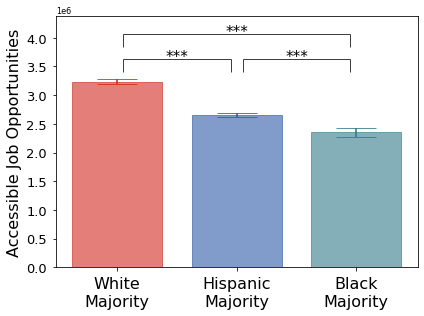

[380.8101157633996, 294.8424183340061, 283.52432906984075]


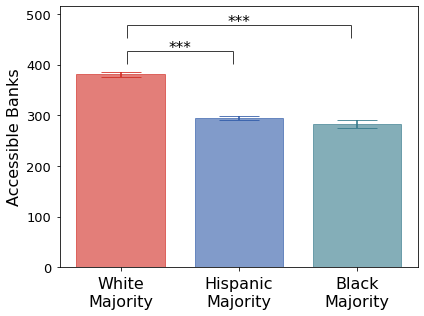

[9329.662919099075, 7352.165960204141, 6687.053944094408]


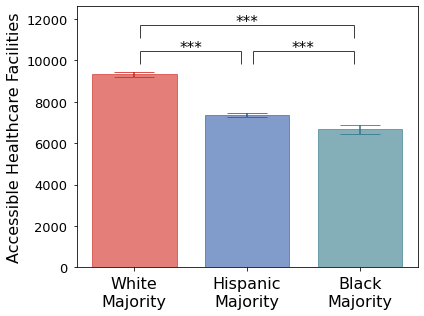

[526.484341971732, 396.458974105097, 379.63079512438827]


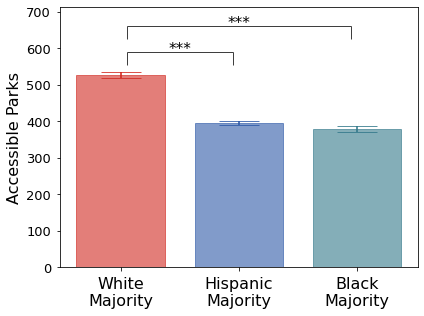

[1519.0101251632645, 1140.1621690342681, 1122.608120522484]


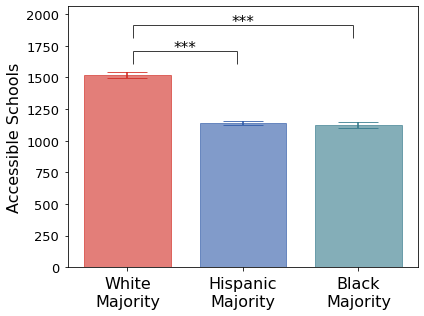

In [9]:
# Compare the transit-oriented accessibility across neighbourhoods with different racial backgrounds
draw_fig2_1('reach', thres = 0.6)
draw_fig2_1('job', thres = 0.6)
draw_fig2_1('bank', thres = 0.6, sigs = [1,0,1])
draw_fig2_1('health', thres = 0.6)
draw_fig2_1('park', thres = 0.6, sigs = [1,0,1])
draw_fig2_1('school', thres = 0.6, sigs = [1,0,1])

# Figure 2G

In [10]:
thres = 0.6
temp = city_feats[city_feats['vehicle_rate'] <= thres]
white_cbg = list(temp[temp.non_Hispanic_white_ratio >= 0.5].census_block_group)
black_cbg = list(temp[temp.non_Hispanic_black_ratio >= 0.5].census_block_group)
Hispanic_cbg = list(temp[temp.Hispanic_ratio >= 0.5].census_block_group)
def get_race(x):
    if x in white_cbg:
        return 'white'
    if x in black_cbg:
        return 'black'
    if x in Hispanic_cbg:
        return 'Hispanic'
    return 'other'
temp['Race'] = [get_race(x) for x in temp.census_block_group]
temp[['non_Hispanic_white_ratio', 'non_Hispanic_black_ratio', 'Hispanic_ratio', 'average_income', 'bachelor_ratio', 'poverty_ratio',
     'unemployed_ratio', 'public_transit_ratio', 'vehicle_rate', 'foreign_born_ratio']] = temp[['non_Hispanic_white_ratio', 'non_Hispanic_black_ratio', 'Hispanic_ratio', 'average_income', 'bachelor_ratio', 'poverty_ratio', 'unemployed_ratio', 'public_transit_ratio', 'vehicle_rate', 'foreign_born_ratio']].fillna(0)
w = temp['Total population']

In [11]:
def control_regression_table_2_2(draw_feat = 'reach', wls_name = False, balanced = False):
    title = feat_dict.get(draw_feat, None)
    mod = wls(draw_feat + " ~ C(Race, Treatment(reference='white'))+unemployed_ratio+foreign_born_ratio+income_percentile+vehicle_rate+public_transit_ratio+poverty_ratio", data=temp, weights = w)
    res = mod.fit()
    print(res.summary())

In [12]:
# Control demograhpic features when regressing transit-oriented accessibility over racial background
for feat in [ 'reach', 'job', 'park',
       'bank', 'health', 'school']:
    control_regression_table_2_2(feat, wls_name = True)

                            WLS Regression Results                            
Dep. Variable:                  reach   R-squared:                       0.348
Model:                            WLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     243.3
Date:                Wed, 01 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:30:44   Log-Likelihood:                -7440.5
No. Observations:                4109   AIC:                         1.490e+04
Df Residuals:                    4099   BIC:                         1.496e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

# Figure 3

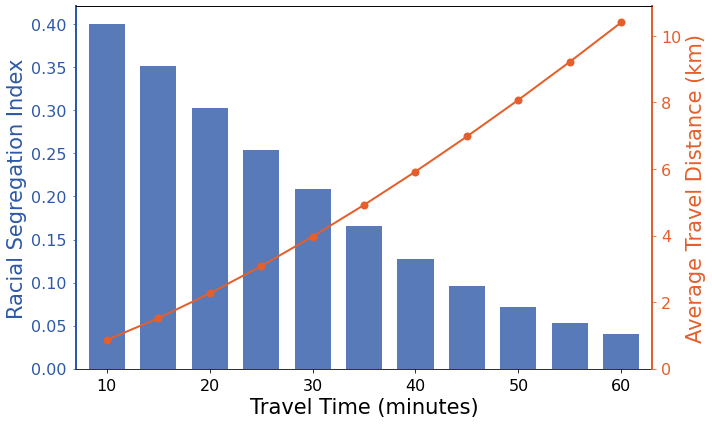

In [13]:
# segregation index under different travel times
vthres = 0.6
temp = city_feats[city_feats.vehicle_rate <= vthres]
ds = list(range(10, 61, 5))
segs = []
for d in ds:
    ttemp = temp.dropna(subset = ['real_KL_'+str(d), 'Total population'])
    segs.append(np.average(ttemp['real_KL_'+str(d)], weights = ttemp['Total population']))
charac_dists = [ 0.8625723 ,  1.51555109,  2.26069127,  3.08283798,  3.97206484,
        4.92125074,  5.92498161,  6.97897112,  8.07972259,  9.2243169 ,
       10.41027204]
color1 = '#2E59A7'
color2 = '#E45F2B'
fig = plt.figure(figsize = (10, 6))
plt.style.use('seaborn-paper')
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.spines['left'].set(color = color1, linewidth = 2)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set(color = color2, linewidth = 2)
ds = list(range(10, 61, 5))
ax1.bar(ds, segs, width = 3.5, hatch = None, color = color1, label = 'Public Transit', alpha = 0.8)
ax1.set_xlim(7, 63)
# ax1.legend(fontsize = 16)
ax1.set_ylabel('Racial Segregation Index', size = 21, color = color1)
ax1.tick_params(axis = 'y', labelsize = 16, color = color1, labelcolor = color1)
ax1.tick_params(axis = 'x', labelsize = 16)
ax1.set_xlabel('Travel Time (minutes)', size = 21)
ax2.plot(ds, charac_dists, color = color2, lw = 2, marker = 'o', markersize = 8)
ax2.set_ylabel('Average Travel Distance (km)', size = 21, color = color2)
ax2.tick_params(axis ='y', labelsize = 16, color = color2, labelcolor = color2)
ax2.set_ylim(0, None)
plt.tight_layout()
plt.show()

In [14]:
# segregation index of different races
vthres = 0.6
temp = city_feats[city_feats.vehicle_rate <= vthres]
ds = list(range(10, 61, 5))
white_seg = []
white_low = []
white_high = []
black_seg = []
black_low = []
black_high = []
Hispanic_seg = []
Hispanic_low = []
Hispanic_high = []
for d in ds:
    ttemp_A = temp[temp.Race == 'white']
    white_seg.append(np.average(ttemp_A['real_KL_'+str(d)], weights = ttemp_A['Total population']))
    bstrap_result = []
    for k in range(1000):
        bstrap_result.append(ttemp_A['real_KL_'+str(d)].sample(n = ttemp_A.shape[0], replace = True, weights = ttemp_A['Total population']).mean())
    white_low.append(np.percentile(bstrap_result, 2.5))
    white_high.append(np.percentile(bstrap_result, 97.5))
    ttemp_A = temp[temp.Race == 'black']
    black_seg.append(np.average(ttemp_A['real_KL_'+str(d)], weights = ttemp_A['Total population']))
    bstrap_result = []
    for k in range(1000):
        bstrap_result.append(ttemp_A['real_KL_'+str(d)].sample(n = ttemp_A.shape[0], replace = True, weights = ttemp_A['Total population']).mean())
    black_low.append(np.percentile(bstrap_result, 2.5))
    black_high.append(np.percentile(bstrap_result, 97.5))
    ttemp_A = temp[temp.Race == 'Hispanic']
    Hispanic_seg.append(np.average(ttemp_A['real_KL_'+str(d)], weights = ttemp_A['Total population']))
    bstrap_result = []
    for k in range(1000):
        bstrap_result.append(ttemp_A['real_KL_'+str(d)].sample(n = ttemp_A.shape[0], replace = True, weights = ttemp_A['Total population']).mean())
    Hispanic_low.append(np.percentile(bstrap_result, 2.5))
    Hispanic_high.append(np.percentile(bstrap_result, 97.5))

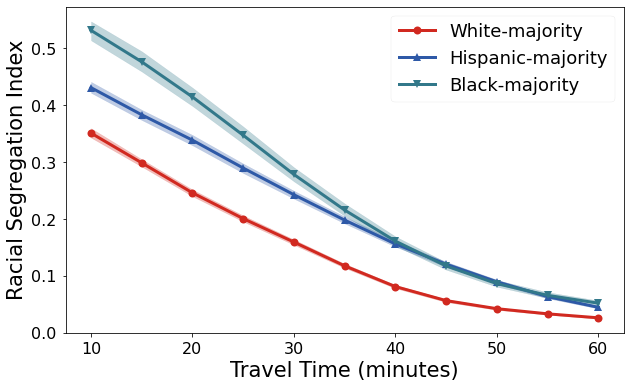

In [15]:
fig = plt.figure(figsize = (10, 6))
colors = ['#D12920', '#2E59A7', '#32788A']
plt.plot(ds, white_seg, color = '#D12920', lw = 3, marker = 'o', markersize = 8, label = 'White-majority')
plt.plot(ds, Hispanic_seg, color = '#2E59A7', lw = 3, marker = '^', markersize = 8, label = 'Hispanic-majority')
plt.plot(ds, black_seg, color = '#32788A', lw = 3, marker = 'v', markersize = 8, label = 'Black-majority')
plt.fill_between(ds, white_low, white_high, color = '#D12920', alpha = 0.3)    
plt.fill_between(ds, Hispanic_low, Hispanic_high, color = '#2E59A7', alpha = 0.3)    
plt.fill_between(ds, black_low, black_high, color = '#32788A', alpha = 0.3)
plt.xlabel('Travel Time (minutes)', size = 21)
plt.ylabel('Racial Segregation Index', size = 21)
plt.xticks(size = 16)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], size = 16)
plt.legend(fontsize = 18)
plt.ylim(0, None)
plt.show()

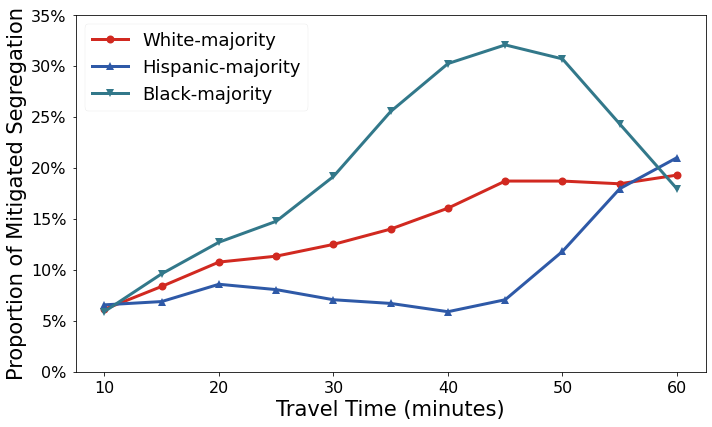

In [16]:
# proportion of mitigated segregation index
vthres = 0.6
temp = city_feats[city_feats.vehicle_rate <= vthres]
ds = list(range(10, 61, 5))
white_portion = []
black_portion = []
Hispanic_portion = []
for d in ds:
    ttemp_A = temp[temp.Race == 'white']
    white_portion.append(1 - np.average(ttemp_A['equity_KL_'+str(d)], weights = ttemp_A['Total population']) / np.average(ttemp_A['real_KL_'+str(d)], weights = ttemp_A['Total population']))
    ttemp_A = temp[temp.Race == 'black']
    black_portion.append(1 - np.average(ttemp_A['equity_KL_'+str(d)], weights = ttemp_A['Total population']) / np.average(ttemp_A['real_KL_'+str(d)], weights = ttemp_A['Total population']))
    ttemp_A = temp[temp.Race == 'Hispanic']
    Hispanic_portion.append(1 - np.average(ttemp_A['equity_KL_'+str(d)], weights = ttemp_A['Total population']) / np.average(ttemp_A['real_KL_'+str(d)], weights = ttemp_A['Total population']))
fig = plt.figure(figsize = (10, 6))
colors = ['#D12920', '#2E59A7', '#32788A']
plt.plot(ds, white_portion, color = '#D12920', lw = 3, marker = 'o', markersize = 8, label = 'White-majority')
plt.plot(ds, Hispanic_portion, color = '#2E59A7', lw = 3, marker = '^', markersize = 8, label = 'Hispanic-majority')
plt.plot(ds, black_portion, color = '#32788A', lw = 3, marker = 'v', markersize = 8, label = 'Black-majority')
plt.xlabel('Travel Time (minutes)', size = 21)
plt.ylabel('Proportion of Mitigated Segregation', size = 21)
plt.xticks(size = 16)
plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%'], size = 16)
plt.legend(fontsize = 18)
plt.ylim(0, 0.35)
plt.tight_layout()
plt.show()

## Figure 4

In [17]:
def draw_4cut(cfeat, featx, featy, xlab, ylab):
    pls = []
    y1s = []
    y2s = []
    nocar = cfeat[cfeat['vehicle_rate'] <= 0.6]
    nocar['cut_poi'], bins = pd.qcut(nocar[featx], 4, labels = [1,2,3,4], retbins = True)
    for i in [1, 2, 3, 4]:
        temp = nocar[nocar['cut_poi'] == i]
        temp = temp.dropna(subset = [featy])
        pls.append(np.average(temp[featy], weights = temp['Total population']))
        bstrap_result = []
        for k in range(200):
            bstrap_result.append(temp[featy].sample(n = temp.shape[0], replace = True, weights =  temp['Total population']).mean())
        low, high = np.percentile(bstrap_result, [2.5, 97.5])
        y1s.append(low)
        y2s.append(high)
        if i == 1:
            lowest = np.array(temp[featy])
        elif i == 4:
            highest = np.array(temp[featy])
    colors = ['#D12920', '#2E59A7', '#32788A', '#F99137']
    plt.figure(figsize = (6, 4.5))
    plt.style.use('seaborn-paper')
    er = np.abs(np.array([y1s, y2s]) - np.array(pls))
    plt.bar([1,2,3,4], height = pls, width = 0.75, color = colors, edgecolor = colors,
            linewidth = 2, alpha = 0.6)
    for i in range(4):
        plt.errorbar([i+1], y = [pls[i]], yerr = er[:, i:i+1], fmt = 'o', markersize = 0, ecolor = colors[i],
                capsize = 20, elinewidth = 2, capthick = 1, alpha = 0.8)
    plt.xticks([1,2,3,4], ['First\nQuartile', 'Second\nQuartile', 'Third\nQuartile','Fourth\nQuartile'], size = 14)
    plt.yticks(size = 14)
    plt.xlabel(xlab, size = 18)
    plt.ylabel(ylab, size = 17)
    plt.tight_layout()
    print(pls)
    print(ttest_ind(lowest, highest))
    plt.show()

[10.563529945176562, 11.12513483337444, 11.469834757734084, 12.127331591626433]
Ttest_indResult(statistic=-15.754142437036432, pvalue=7.079447834849745e-53)


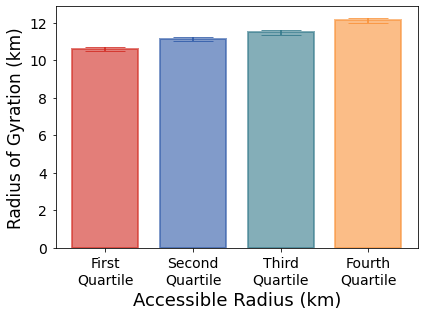

[0.11957523130774496, 0.10628668798686994, 0.09128201229211201, 0.06151857161978758]
Ttest_indResult(statistic=17.73888402881512, pvalue=1.2681035847113657e-65)


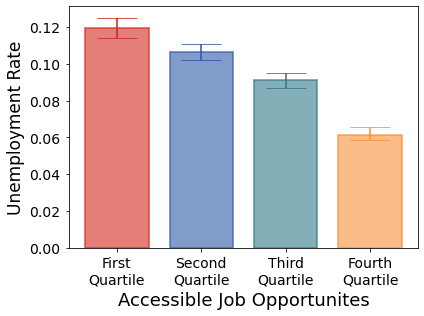

[6.840692788920351, 6.395623325574894, 5.846257452759536, 5.2776541808651745]
Ttest_indResult(statistic=3.8375762431139693, pvalue=0.00013494056253822358)


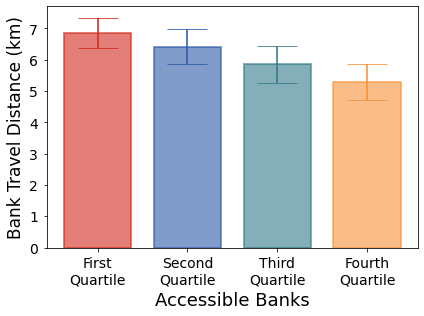

[7.47059483282714, 6.906652244713157, 6.523586226315244, 6.642309062956887]
Ttest_indResult(statistic=9.94132304401286, pvalue=8.898421124589451e-23)


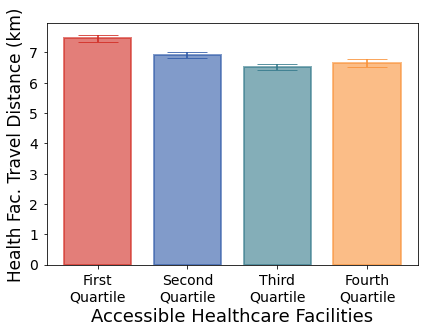

[8.460451827798746, 7.678709020924432, 7.441163319428062, 6.801081278893316]
Ttest_indResult(statistic=19.45978768587782, pvalue=1.5104748239505402e-77)


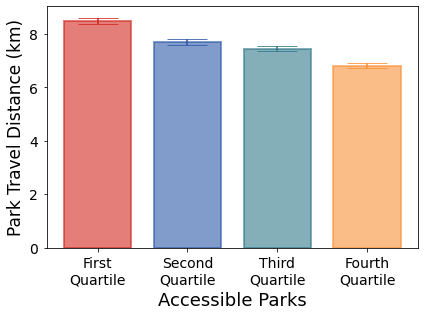

[7.4375857469231965, 6.930038978826113, 6.465742426717279, 5.962958498128486]
Ttest_indResult(statistic=15.027996885350154, pvalue=1.6363171328502417e-48)


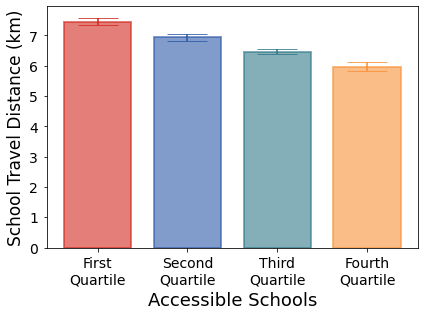

In [18]:
# Compare the average behavioural patterns across neighbourhoods with different levels of transit-oriented accessibility
draw_4cut(city_feats, 'reach', 'gyr', 'Accessible Radius (km)', 'Radius of Gyration (km)')
draw_4cut(city_feats, 'job', 'unemployed_ratio','Accessible Job Opportunites', 'Unemployment Rate')
draw_4cut(city_feats, 'bank', 'bank_dist', 'Accessible Banks', 'Bank Travel Distance (km)')
draw_4cut(city_feats, 'health', 'health_dist', 'Accessible Healthcare Facilities', 'Health Fac. Travel Distance (km)')
draw_4cut(city_feats, 'park', 'park_dist', 'Accessible Parks', 'Park Travel Distance (km)')
draw_4cut(city_feats, 'school', 'school_dist', 'Accessible Schools', 'School Travel Distance (km)')

# Figure 5A

In [19]:
nocar = city_feats[city_feats['vehicle_rate'] <= 0.6]
white_cbg = list(nocar[nocar.non_Hispanic_white_ratio >= 0.5].census_block_group)
black_cbg = list(nocar[nocar.non_Hispanic_black_ratio >= 0.5].census_block_group)
Hispanic_cbg = list(nocar[nocar.Hispanic_ratio >= 0.5].census_block_group)
def get_race(x):
    if x in white_cbg:
        return 'white'
    if x in black_cbg:
        return 'black'
    if x in Hispanic_cbg:
        return 'Hispanic'
    return 'other'
def get_race_num(x):
    if x in white_cbg:
        return 1
    if x in black_cbg:
        return 3
    if x in Hispanic_cbg:
        return 2
    return np.nan
nocar['Race'] = [get_race(x) for x in nocar.census_block_group]
nocar['Race_num'] = [get_race_num(x) for x in nocar.census_block_group]

11 [1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0, 11000.0] [10.107374981021573, 8.500297350350131, 7.905471606536262, 7.585376338340664, 7.278472469610647, 7.221340812536207, 7.0619559353265915, 6.610181060261167, 6.107049019211142, 6.131239971210385, 6.399197015661322]
11 [1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0, 11000.0] [8.303314115421614, 7.626194660071578, 7.130189622910826, 6.836258659623268, 6.7818161513319435, 6.914722312246793, 6.878813707953843, 6.845756675187841, 6.693085250278965, 6.639638979749554, 6.6019334785411345]
11 [1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0, 11000.0] [8.535729686340604, 8.191114677291086, 7.715280221674861, 7.2314673449710165, 6.953396455901498, 6.57863999802128, 6.547182014437861, 6.591253760882729, 6.643379299275669, 6.647791648700404, 6.5556446074179044]


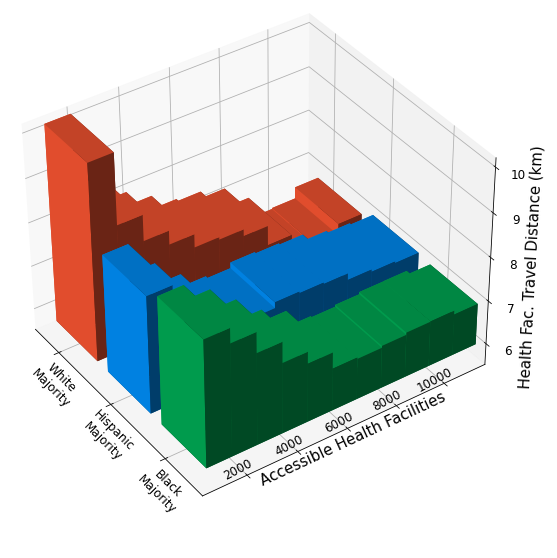

In [20]:
# Compare the average travel distance to healthcare facilities to health accessibility across 3 races
bins = np.linspace(1000, 11000, 11)
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=38, azim=-35)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.9, 1, 1, 1]))
cls = ['#FF5733', '#0092FF', '#00B057'] # FF5733的 threedom
places = [0, 1.5, 2.0, 2.5]
z_bot = 5.6

for race in [1, 2, 3]:
    x = []
    y = []
    dy = []
    h = []
    dx = bins[1] - bins[0]
    temp_race = nocar[nocar.Race_num == race]
    temp_race = temp_race.dropna(subset = ['health', 'health_dist'])
    for i in range(len(bins)):
        temp = temp_race[(temp_race.health > bins[i]- 1.5*dx) & (temp_race.health <= bins[i]+ 1.5*dx)]
        if temp.shape[0] == 0:
            print(race, i)
            pass
        else:
            x.append(places[race])
            y.append(bins[i])
            dy.append(temp.shape[0] / temp_race.shape[0] * 1.5)
            h.append(np.average(temp.health_dist, weights = temp['Total population']))
    z_bottom = np.array(x) * 0 + z_bot
    print(len(x), y, h)
    pl = ax.bar3d(x, y, z_bottom, 0.4, dx, h - z_bottom, shade = True, color = cls[race-1], alpha = 1.0)
    pl._sort_zpos = race
    
ax.set_ylabel('Accessible Health Facilities', size = 15, labelpad = -13)
ax.set_zlabel('Health Fac. Travel Distance (km)', size = 15)
ax.set_zlim(z_bot, None)
plt.xticks([1.7, 2.2, 2.7], ['White\nMajority', 'Hispanic\nMajority', 'Black\nMajority'], size = 12, rotation = -45, ha = 'center')
ax.tick_params(axis='x', pad = -5)
ax.tick_params(axis='y', labelsize=12, pad = -22, rotation = 28)
ax.tick_params(axis='z', labelsize=12)

xlim_max = 3
ax.set_xlim(1.5, xlim_max)
ax.set_ylim(500, 11500)

plt.show()

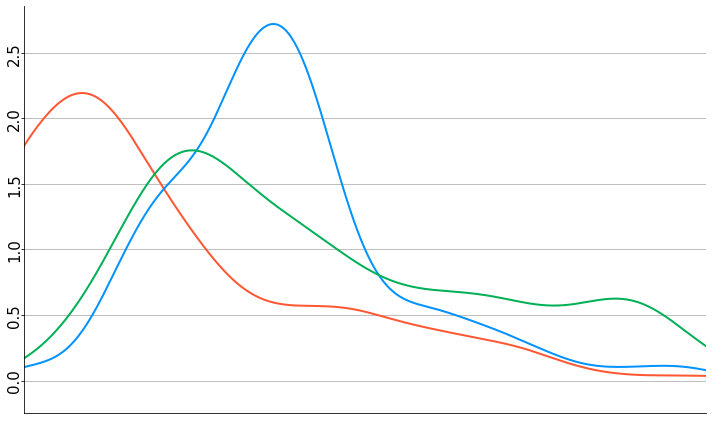

In [21]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for race in [1, 2, 3]:
    temp_race = nocar[nocar.Race_num == race]
    temp_race = temp_race.dropna(subset = ['health', 'health_dist'])
    kde = stats.gaussian_kde(temp_race.health, weights = temp_race['Total population'])
    x_vals = np.linspace(500, 11500, 1000)
    density = kde(x_vals)
    plt.plot(x_vals, density, color = cls[race-1], lw = 2)
plt.xlim(500, 11500)
plt.xticks([])
plt.ylim(-2.5e-5, None)
plt.yticks([0, 5e-5, 10e-5, 15e-5, 20e-5, 25e-5 ], ['0.0', '0.5', '1.0', '1.5', '2.0', '2.5'], rotation = 90, size = 15, ha = 'center', va = 'center')
ax.yaxis.grid(True, ydata = [1e-5])
ax.invert_xaxis()
plt.tight_layout()
plt.show()

# Figure 6

In [22]:
city = 'newyork'
curr_gpd = gpd.read_file('data/newyork.geojson')

In [23]:
# Draw the spatial distribution of NYCHA developments and accessible radius
thres = 0.6
temp = city_feats[city_feats['vehicle_rate'] <= thres]
white_cbg = list(temp[temp.non_Hispanic_white_ratio >= 0.5].census_block_group)
black_cbg = list(temp[temp.non_Hispanic_black_ratio >= 0.5].census_block_group)
Hispanic_cbg = list(temp[temp.Hispanic_ratio >= 0.5].census_block_group)
def get_race(x):
    if x in white_cbg:
        return 'white'
    if x in black_cbg:
        return 'black'
    if x in Hispanic_cbg:
        return 'Hispanic'
    return 'other'
temp['Race'] = [get_race(x) for x in temp.census_block_group]
temp[['non_Hispanic_white_ratio', 'non_Hispanic_black_ratio', 'Hispanic_ratio', 'average_income', 'bachelor_ratio', 'poverty_ratio',
     'unemployed_ratio', 'public_transit_ratio', 'vehicle_rate', 'foreign_born_ratio']] = temp[['non_Hispanic_white_ratio', 'non_Hispanic_black_ratio', 'Hispanic_ratio', 'average_income', 'bachelor_ratio', 'poverty_ratio', 'unemployed_ratio', 'public_transit_ratio', 'vehicle_rate', 'foreign_born_ratio']].fillna(0)
w = temp['Total population']

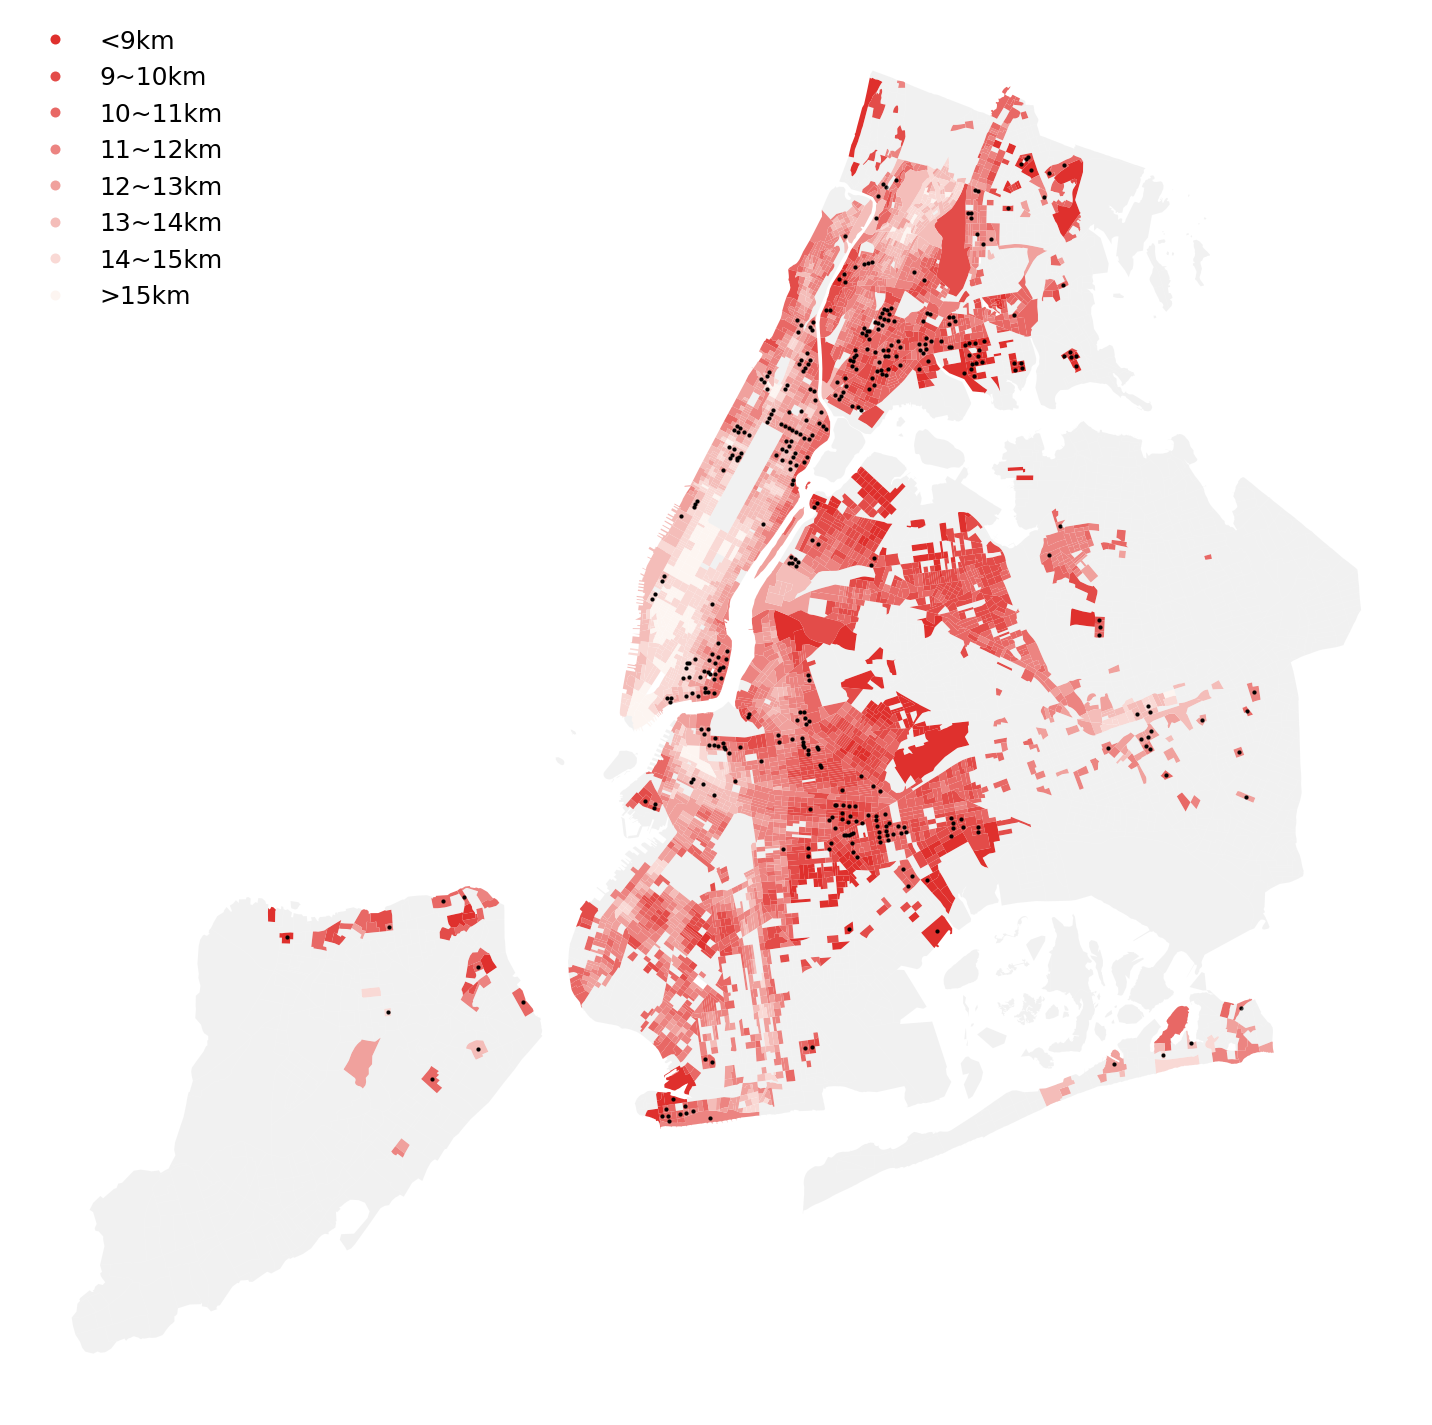

In [24]:
mycmap = mpl.colors.LinearSegmentedColormap.from_list('lwide', [(0, '#DF302D'), (1, '#FDF5F1')], N=256)
nycha_cbgs = city_feats[city_feats.public_housing_district].census_block_group
curr_gpd1 = pd.merge(curr_gpd.to_crs("EPSG:3857"), city_feats[['census_block_group', 'vehicle_rate', 'reach']], on = 'census_block_group', how = 'left')
curr_gpd1['ttime'] = pd.cut(curr_gpd1.reach, [0, 9, 10, 11, 12, 13, 14, 15, 10000], labels = ['<9km', '9~10km', '10~11km', '11~12km', '12~13km', '13~14km', '14~15km', '>15km'])
base = curr_gpd1.boundary.plot(figsize = (20, 20), lw = 0.0, color = 'black')
curr_gpd1[curr_gpd1.vehicle_rate <= 0.6].plot(ax = base, column = 'ttime', colormap = mycmap, legend = True, legend_kwds = {'frameon': False, 'loc': 'upper left', 'fontsize': 25})
curr_gpd1[(curr_gpd1.vehicle_rate <= 0.6) & (curr_gpd1.census_block_group.isin(nycha_cbgs))].centroid.plot(ax = base, color = 'black', markersize = 15)
nocars = curr_gpd1[curr_gpd1.vehicle_rate <= 0.6].census_block_group
curr_gpd1[~curr_gpd1.census_block_group.isin(nocars)].plot(ax = base, color = 'lightgrey', alpha = 0.3)
base.axis('off')
plt.tight_layout()
plt.show()

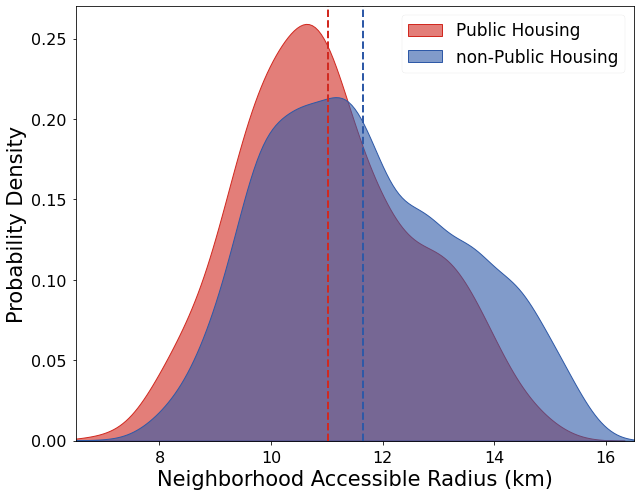

In [25]:
# compare accessible radius between public and non-public housing
draw_feat = 'reach'
colors = ['#D12920', '#2E59A7', '#32788A']
plt.figure(figsize=(9, 7))
sns.kdeplot(data=city_feats[city_feats['vehicle_rate'] <= 0.6], palette = ['#2E59A7', '#D12920'], legend = False, hue_order = [False, True], x=draw_feat, hue="public_housing_district", fill=True, common_norm=False, alpha=.6, linewidth=1,)
plt.xlim(6.5, 16.5)
plt.ylim(0, 0.27)
plt.vlines(11.014574566055146, 0, 0.27, color = colors[0], ls = '--', lw = 2)
plt.vlines(11.649709917240532, 0, 0.27, color = colors[1], ls = '--', lw = 2)
plt.xticks( size = 16)
plt.yticks( size = 16)
plt.legend(labels = ['Public Housing', 'non-Public Housing'], fontsize = 17, loc = 'upper right')
plt.ylabel('Probability Density', size = 21)
plt.xlabel('Neighborhood Accessible Radius (km)', size = 21)
plt.tight_layout()
plt.show()

In [26]:
def calc_difference(dfeat):
    pls = []
    for feat in [True, False]:
        temp = city_feats[city_feats['public_housing_district'] == feat]
        temp = temp[temp['vehicle_rate'] <= 0.6]
        temp = temp.dropna(subset = [dfeat])
        pls.append(np.average(temp[dfeat], weights = temp['Total population']))
    ph_difference = pls[1] - pls[0]
    city_feats[dfeat+'_new'] = city_feats['public_housing_district']*ph_difference+city_feats[dfeat]
    
    pls = []
    for feat in ['non_Hispanic_white_ratio', 'Hispanic_ratio', 'non_Hispanic_black_ratio']:
        temp = city_feats[city_feats[feat] >= 0.5]
        temp = temp[temp['vehicle_rate'] <= 0.6]
        temp = temp.dropna(subset = [dfeat])
        pls.append(np.average(temp[dfeat], weights = temp['Total population']))
    
    pls_f = []
    draw_feat = dfeat + '_new'
    for feat in ['non_Hispanic_white_ratio', 'Hispanic_ratio', 'non_Hispanic_black_ratio']:
        temp = city_feats[city_feats[feat] >= 0.5]
        temp = temp[temp['vehicle_rate'] <= 0.6]
        temp = temp.dropna(subset = [draw_feat])
        pls_f.append(np.average(temp[draw_feat], weights = temp['Total population']))
    return [(pls[0] - pls[1])/pls[1], (pls[0] - pls[2]) / pls[2], (pls_f[0] - pls_f[1])/pls_f[1], (pls_f[0] - pls_f[2])/pls_f[2]]

[0.12115448635336266, 0.17857247427165548, 0.11106728604416125, 0.1644236411092817]


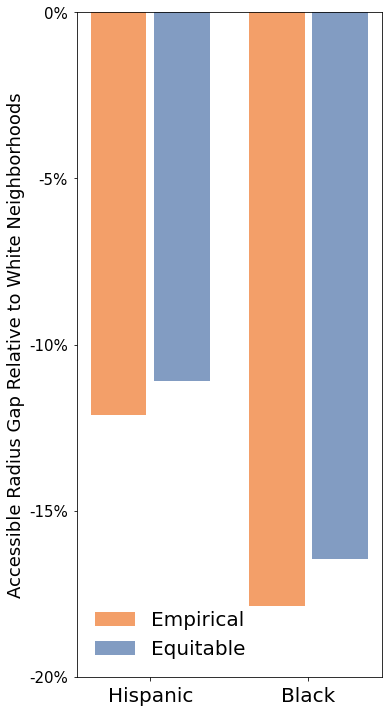

In [27]:
# Simulation Experiments: improve transit-oriented accessibility in public housing neighbourhoods
a = calc_difference('reach')
print(a)
a = np.array(a)*(-1)
fig = plt.figure(figsize = (5.5, 10))
plt.style.use('seaborn-paper')
ax1 = fig.add_subplot(111)
ax1.bar([0.8,1.8], height = a[0:2], width = 0.35, color = '#F08743',
        linewidth = 1, alpha = 0.8, label = 'Empirical')
ax1.bar([1.2,2.2], height = a[2:4], width = 0.35, color = '#6384B3',
        linewidth = 1, alpha = 0.8, label = 'Equitable')
ax1.legend(fontsize = 20, frameon = False)
ax1.tick_params(axis = 'x', labelsize = 20)
ax1.tick_params(axis = 'y', labelsize = 15)
ax1.set_xticks([1,2])
ax1.set_xticklabels(['Hispanic', 'Black'])
ax1.set_yticks([0, -0.05, -0.10, -0.15, -0.2])
ax1.set_yticklabels(['0%', '-5%', '-10%', '-15%', '-20%'])
ax1.set_ylim(None, 0)
ax1.set_ylabel('Accessible Radius Gap Relative to White Neighborhoods', size = 18)
plt.tight_layout()
plt.show()

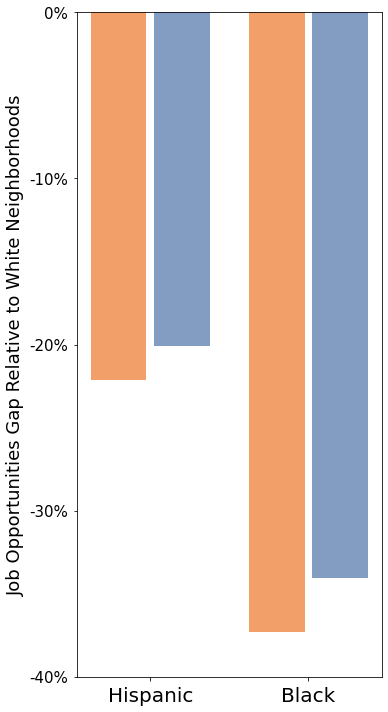

In [28]:
a = calc_difference('job')
a = np.array(a)*(-1)
fig = plt.figure(figsize = (5.5, 10))
plt.style.use('seaborn-paper')
ax1 = fig.add_subplot(111)
ax1.bar([0.8,1.8], height = a[0:2], width = 0.35, color = '#F08743',
        linewidth = 1, alpha = 0.8, label = 'Empirical')
ax1.bar([1.2,2.2], height = a[2:4], width = 0.35, color = '#6384B3',
        linewidth = 1, alpha = 0.8, label = 'Equitable')
# ax1.legend(fontsize = 20, frameon = False)
ax1.tick_params(axis = 'x', labelsize = 20)
ax1.tick_params(axis = 'y', labelsize = 15)
ax1.set_xticks([1,2])
ax1.set_xticklabels(['Hispanic', 'Black'])
ax1.set_yticks([0, -0.10, -0.20, -0.30, -0.4])
ax1.set_yticklabels(['0%', '-10%', '-20%', '-30%', '-40%'])
ax1.set_ylim(None, 0)
ax1.set_ylabel('Job Opportunities Gap Relative to White Neighborhoods', size = 18)
plt.tight_layout()
plt.show()